### Domain: Machine Translation

### Dataset: Hindi_English_Truncated_Corpus.csv

### Question: Build  an  encoder-decoder  model  to  predict  Hindi  sentences  from  a  given  English sentence


#### Import the required liberaries 

In [1]:
import numpy as np 
import pandas as pd 

import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re

#import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from tensorflow.keras.utils import plot_model

from nltk.translate.bleu_score import corpus_bleu

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

#### Load the  Hindi_English_Truncated_Corpus.csv data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls -ltr "/content/drive/My Drive/Dataset/Seq_Learn_Assign_3"

total 105866
-rw------- 1 root root 41399186 Oct 24  2019 Hindi_English_Truncated_Corpus.csv
drwx------ 2 root root     4096 Apr 19 13:11 Flickr8k_text
drwx------ 2 root root     4096 Apr 19 13:30 Flicker8k_images
-rw------- 1 root root 66999214 Apr 25 11:49 features_Flickr8k_images_new.pkl


In [4]:
hindi_file = '/content/drive/My Drive/Dataset/Seq_Learn_Assign_3/Hindi_English_Truncated_Corpus.csv'
data = pd.read_csv(hindi_file)

In [5]:
data.head(10)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what needs to be done.,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है ."
1,ted,"I'd like to tell you about one such child,","मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,"
2,indic2012,This percentage is even greater than the percentage in India.,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not paying attention.,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called Upanishad.,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।
5,tides,"The then Governor of Kashmir resisted transfer , but was finally reduced to subjection with the aid of British .","कश्मीर के तत्कालीन गवर्नर ने इस हस्तांतरण का विरोध किया था , लेकिन अंग्रेजों की सहायता से उनकी आवाज दबा दी गयी ."
6,indic2012,In this lies the circumstances of people before you.,इसमें तुमसे पूर्व गुज़रे हुए लोगों के हालात हैं।
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
8,indic2012,“”Global Warming“” refer to warming caused in recent decades and probability of its continual presence and its indirect effect on human being.,ग्लोबल वॉर्मिंग से आशय हाल ही के दशकों में हुई वार्मिंग और इसके निरंतर बने रहने के अनुमान और इसके अप्रत्यक्ष रूप से मानव पर पड़ने वाले प्रभाव से है।
9,tides,You may want your child to go to a school that is not run by the LEA - a non-maintained special school or an independent school that can meet your child 's needs .,"हो सकता है कि आप चाहते हों कि आप का नऋर्नमेनटेन्ड ह्यबिना किसी समर्थन के हृ विशेष स्कूल , या किसी स्वतंत्र स्कूल में जाए , इजसके पास विशेष शैक्षणिक जऋऋरतों वाले बच्चों के प्रति सहूलियत हों . ."


In [6]:
print(data.shape)

(127607, 3)


#### Create new dataframe

In [7]:
df = data[data['source'] == 'ted']
df

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what needs to be done.,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है ."
1,ted,"I'd like to tell you about one such child,","मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,"
3,ted,what we really mean is that they're bad at not paying attention.,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
13,ted,So there is some sort of justice,तो वहाँ न्याय है
...,...,...,...
127595,ted,is if we want that to become our reality -,अगर हम चाहते हैं कि यह वास्तविकता बने -
127597,ted,Africa has not done bad.,अफ़्रीका ने कुछ गलती नहीं की है।
127598,ted,Thank you.,धन्यवाद |
127603,ted,and put it in our cheeks.,और अपने गालों में डाल लेते हैं।


## 1. Data Preprocessing

In [8]:
# Searching for null value  columns 
pd.isnull(df).sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

In [9]:
# Droping duplicate rows 
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(39881, 3)
(38803, 3)


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [10]:
## Data Cleanup

# Lowercase all text for processing
df['english_sentence'] = df['english_sentence'].apply(lambda x: x.lower())
df['hindi_sentence'] = df['hindi_sentence'].apply(lambda x: x.lower())



# Remove the quotes from all text for processing
df['english_sentence']=df['english_sentence'].apply(lambda x: re.sub("'", '', x))
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: re.sub("'", '', x))




# Remove all the special characters for processing
special_char = set(string.punctuation) 
df['english_sentence']=df['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in special_char))
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in special_char))



# Remove all the digits from text for processing
digits = str.maketrans('', '', digits)
df['english_sentence']=df['english_sentence'].apply(lambda x: x.translate(digits))
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: x.translate(digits))



# Remove the extra spaces from text for processing
df['english_sentence']=df['english_sentence'].apply(lambda x: x.strip())
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: x.strip())
df['english_sentence']=df['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))



# Add start and end tokens to target sequences for processing
df['hindi_sentence'] = df['hindi_sentence'].apply(lambda x : 'START_ '+ x + ' _END')


df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what needs to be done,START_ राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करने कि अनुमति नहीं है _END
1,ted,id like to tell you about one such child,START_ मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी _END
3,ted,what we really mean is that theyre bad at not paying attention,START_ हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते _END
7,ted,and who are we to say even that they are wrong,START_ और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं _END
13,ted,so there is some sort of justice,START_ तो वहाँ न्याय है _END


In [11]:
### Creating set of English Vocabularies
all_eng_words=set()
for sent in df['english_sentence']:
    for word in sent.split():
        all_eng_words.add(word)
        
        
### Creating set of Hindi Vocabularies
all_hindi_words=set()
for hind in df['hindi_sentence']:
    for word in hind.split():
        all_hindi_words.add(word)

In [12]:
print('Hindi_words_length: ',len(all_hindi_words))
print('English_words_length: ', len(all_hindi_words))

Hindi_words_length:  22526
English_words_length:  22526


##### Sorting Vocabularies 

In [13]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))

In [14]:
num_encoder_tokens = len(input_words) + 1 # for zero padding
num_decoder_tokens = len(target_words) + 1 # for zero padding

print('Encoder tokens:',num_encoder_tokens, 'Decoder tokens:',num_decoder_tokens)

Encoder tokens: 17346 Decoder tokens: 22527


#### Creating token index & reverse token index

In [15]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

##### Input token index 

In [16]:
items = input_token_index.items()
list(items)[:10]

[('a', 1),
 ('aaaahhh', 2),
 ('aaron', 3),
 ('ab', 4),
 ('abacha', 5),
 ('abandon', 6),
 ('abandoned', 7),
 ('abattoirs', 8),
 ('abbottabad', 9),
 ('abc', 10)]

#### Reverse input token index  

In [17]:
items = reverse_input_char_index.items()
list(items)[:10]

[(1, 'a'),
 (2, 'aaaahhh'),
 (3, 'aaron'),
 (4, 'ab'),
 (5, 'abacha'),
 (6, 'abandon'),
 (7, 'abandoned'),
 (8, 'abattoirs'),
 (9, 'abbottabad'),
 (10, 'abc')]

#### Calculating length of each sentance and storing in new column for hindi and english 

In [18]:
df['length_eng_sentence']=df['english_sentence'].apply(lambda x:len(x.split(" ")))
df['length_hind_sentence']=df['hindi_sentence'].apply(lambda x:len(x.split(" ")))
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,source,english_sentence,hindi_sentence,length_eng_sentence,length_hind_sentence
0,ted,politicians do not have permission to do what needs to be done,START_ राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करने कि अनुमति नहीं है _END,12,15
1,ted,id like to tell you about one such child,START_ मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी _END,9,13
3,ted,what we really mean is that theyre bad at not paying attention,START_ हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते _END,12,13
7,ted,and who are we to say even that they are wrong,START_ और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं _END,11,15
13,ted,so there is some sort of justice,START_ तो वहाँ न्याय है _END,7,6


### Using maximum sentence length is 20 for training and test data

In [19]:
max_sent_len =20

df=df[df['length_eng_sentence'] <= max_sent_len]
df=df[df['length_hind_sentence'] <= max_sent_len]

max_length_src=max(df['length_hind_sentence'])
max_length_tar=max(df['length_eng_sentence'])

print("maximum length of Spanish Sentence ",max_length_src)
print("maximum length of English Sentence ",max_length_tar)

df = shuffle(df)

df.head()

maximum length of Spanish Sentence  20
maximum length of English Sentence  20


,source,english_sentence,hindi_sentence,length_eng_sentence,length_hind_sentence
118167,ted,so no one actually needs to muck up the production of sound,START_ तो किसी को भी ये रटने की ज़रूरत नहीं कि ध्वनि कैसे बनती है _END,12,16
17185,ted,that had a majority of deaths resulting from surgery,START_ जोकि सर्जरी से उत्पन्न होने वाली मौतों के मामले में बहुमत में था _END,9,15
41341,ted,i do have a plan,START_ मेरे पास एक योजना है _END,5,7
105096,ted,this is this year in austria,START_ और इस साल ऑस्ट्रिया में _END,6,7
52821,ted,in fact it also shows something interesting,START_ वास्तव में यह ये भी प्रदर्शित करता है कि _END,7,11


#### Data shape after 20 length of sentances filter 

In [20]:
df.shape

(38474, 5)

## 2. Train & Test data split 

In [21]:
X, y = df['english_sentence'], df['hindi_sentence']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print(X.shape, X_train.shape, X_test.shape)

(38474,) (30779,) (7695,)


In [22]:
X_train.head()

48057                                                            when i say realism
82194                                   how do you ask those who were once fighting
74582                                  and im touched so that tears come to my eyes
93075                                                            they get different
101214    theres only been two concepts tried two by the us and one by the russians
Name: english_sentence, dtype: object

### Create a function to generate data 

In [23]:
def generate_data(X = X_train, y = y_train, batch_size = 128):
    
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t < len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t > 0:
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield ([encoder_input_data, decoder_input_data], decoder_target_data)

## 3. Preparing encode and decoder for Model

In [24]:
latent_dim=300

### Encoder 

In [25]:
encoder_inputs = Input(shape=(None, ))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

### Decoder 

In [26]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)


decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

## Preparing model 

In [27]:

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [28]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

#### Ploting the model's architecture 

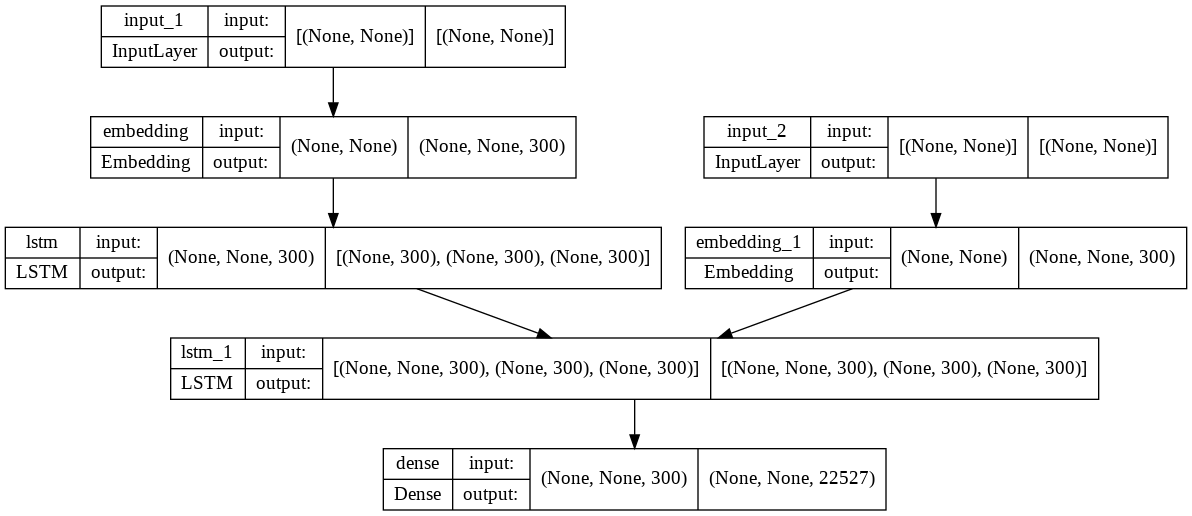

In [29]:
plot_model(model, to_file='model.png', show_shapes=True)

## Training the model

In [30]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 30
    
model.fit_generator(generator = generate_data(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_data(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/30
240/240 [==============================] - 46s 147ms/step - loss: 2.9684 - val_loss: 2.7817
Epoch 2/30
240/240 [==============================] - 30s 126ms/step - loss: 2.6428 - val_loss: 2.6033
Epoch 3/30
240/240 [==============================] - 33s 136ms/step - loss: 2.4828 - val_loss: 2.5309
Epoch 4/30
240/240 [==============================] - 30s 127ms/step - loss: 2.3675 - val_loss: 2.4650
Epoch 5/30
240/240 [==============================] - 33s 137ms/step - loss: 2.2686 - val_loss: 2.4238
Epoch 6/30
240/240 [==============================] - 30s 127ms/step - loss: 2.1791 - val_loss: 2.3925
Epoch 7/30
240/240 [==============================] - 33s 136ms/step - loss: 2.0985 - val_loss: 2.3689
Epoch 8/30
240/240 [==============================] - 30s 127ms/step - loss: 2.0231 - val_loss: 2.3561
Epoch 9/30
240/240 [==============================] - 33s 137ms/step - loss: 1.9521 - val_loss: 2.3460
Epoch 10/30
240/240 [==============================] - 30s 126ms/step - l

In [31]:
model.save('model_machine_translation_eng_hindi_20_Aug_21_rmsprop_30_epoch.h5')

In [32]:
#model = model.load_weights('model_machine_translation_eng_hindi_20_Aug_21_rmsprop_30_epoch.h5')

## Preparing Models for Prediction


#### Encoder:

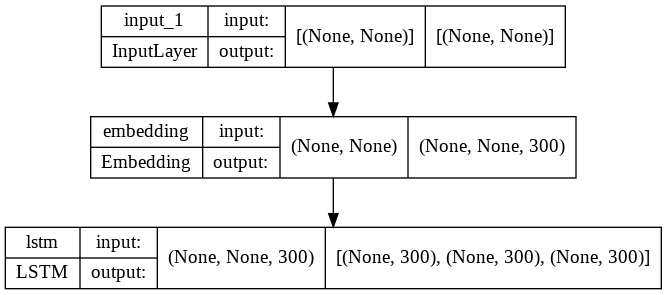

In [33]:
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='pred_model.png', show_shapes=True)

#### Decoder:

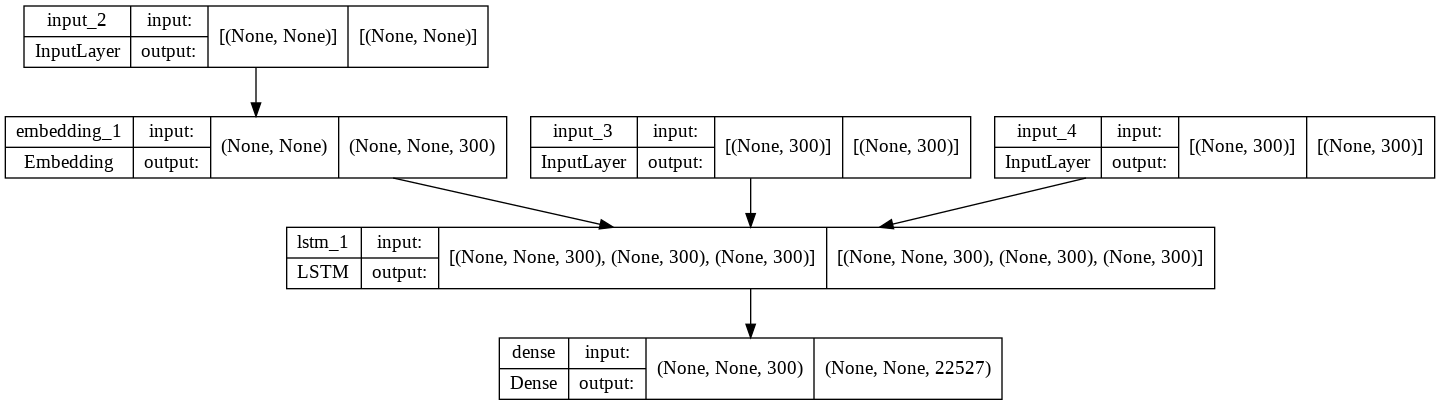

In [34]:
dec_emb2= dec_emb_layer(decoder_inputs)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_outputs2) 


decoder_model = Model( [decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)

plot_model(decoder_model, to_file='model.png', show_shapes=True)

## Translation function

In [35]:
def decode_sequence(input_seq):
    
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_token_index['START_']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        if (sampled_char == '_END' or len(decoded_sentence) > 50):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence

### Preparing test data

In [36]:
test_gen = generate_data(X_test, y_test, batch_size = 1)
k=-1

### Prediction Test 1:  

In [37]:
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Hindi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: solved everything in minutes
Actual Hindi Translation:  सारे सवाल मिनट में हल कर दिए 
Predicted Hindi Translation:  हर किसी ने मिनट में 


### Prediction Test 2:  

In [38]:
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Hindi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: but at the end of the day
Actual Hindi Translation:  परन्तु आखिरकार 
Predicted Hindi Translation:  लेकिन अंत में ही 


### Prediction Test 3:  

In [39]:
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Hindi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: you can draw ground water from any well
Actual Hindi Translation:  नींव का पानी आप कुएँ से प्राप्त कर सकते हैं। 
Predicted Hindi Translation:  तो आप किसी भी उपयोग जा कर सकते हैं 


### Prediction Test 4:  

In [40]:
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Hindi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: and he said “it was humiliating because
Actual Hindi Translation:  और उसने कहा “यह अपमानजनक था क्योंकि 
Predicted Hindi Translation:  और उन्होंने कहा था कि मैने ये सब एक गलत रखा गय


### Prediction Test 5:  

In [41]:
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Hindi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: because it reduces and in some cases even reverses
Actual Hindi Translation:  क्योंकि यह कम कर देता है और कुछ मामलों में भी पराजयों 
Predicted Hindi Translation:  क्योंकि यह कुछ दिनों की उम्र में जा सकता है। 
